In [4]:
!pip install scikit-learn==0.24.2
!pip install cloudpickle==2.0.0


  Using cached scikit-learn-0.24.2.tar.gz (7.5 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... error
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [72 lines of output]
      <string>:17: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
      Partial import of sklearn during the build process.
      <string>:116: DeprecationWarning:
      
        `numpy.distutils` is deprecated since NumPy 1.23.0, as a result
        of the deprecation of `distutils` itself. It will be removed for
        Python >= 3.12. For older Python versions it will remain present.
        It is recommended to use `setuptools < 60.0` for those Python versions.
        For more details, see:
          https://numpy.org/devdocs/reference/distutils_status_migration.html
      
    

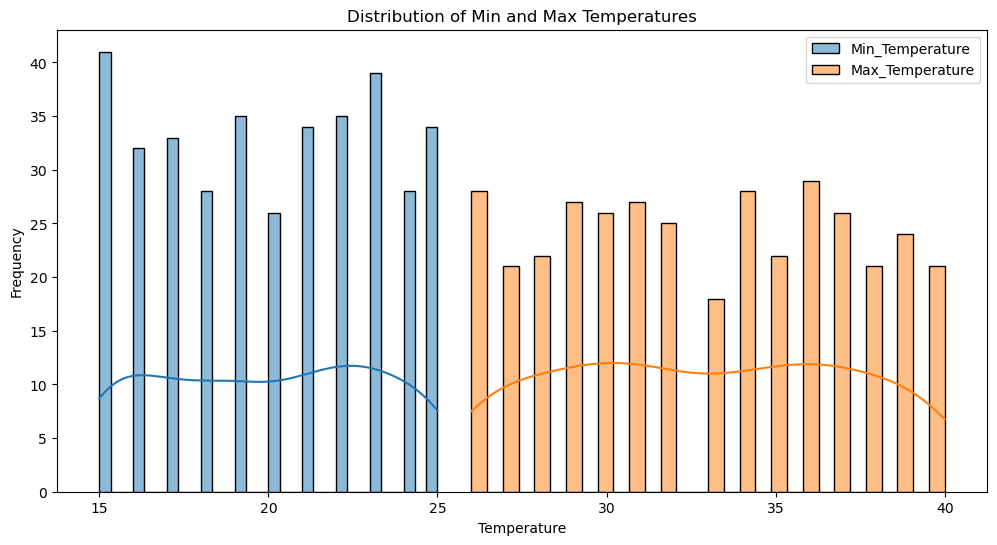

Mean Squared Error for Min_Temperature model: 11.08
Mean Squared Error for Max_Temperature model: 19.39


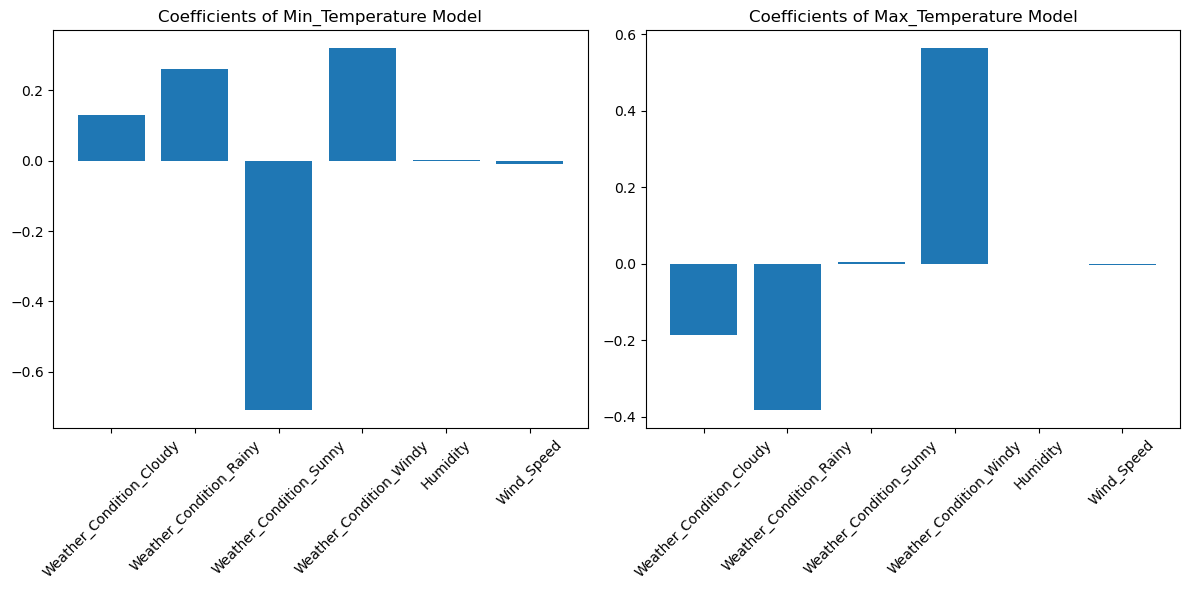

['model_max_t.pkl']

In [5]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
dataset = pd.read_csv("year_lahore_weather_data.csv")  

# Drop irrelevant columns (if any)
dataset = dataset[['Min_Temperature', 'Max_Temperature', 'Humidity', 'Wind_Speed', 'Weather_Condition']]

# Visualize the distribution of Min_Temperature and Max_Temperature
plt.figure(figsize=(12, 6))
sns.histplot(dataset['Min_Temperature'], bins=30, kde=True, label='Min_Temperature')
sns.histplot(dataset['Max_Temperature'], bins=30, kde=True, label='Max_Temperature')
plt.title('Distribution of Min and Max Temperatures')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Split the data into features (X) and target variables (y)
X = dataset.drop(['Min_Temperature', 'Max_Temperature'], axis=1)
y_min_t = dataset['Min_Temperature']
y_max_t = dataset['Max_Temperature']

# Split the data into training and testing sets
X_train, X_test, y_min_t_train, y_min_t_test = train_test_split(X, y_min_t, test_size=0.2, random_state=42)
X_train, X_test, y_max_t_train, y_max_t_test = train_test_split(X, y_max_t, test_size=0.2, random_state=42)

# Define categorical features for one-hot encoding
categorical_features = ['Weather_Condition']

# Create a column transformer to apply one-hot encoding to categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='if_binary'), categorical_features)
    ],
    remainder='passthrough'
)

# Create a pipeline with preprocessing and linear regression model
model_min_t = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

model_max_t = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train Linear Regression models
model_min_t.fit(X_train, y_min_t_train)
model_max_t.fit(X_train, y_max_t_train)



# Predictions on the test set
y_min_t_pred = model_min_t.predict(X_test)
y_max_t_pred = model_max_t.predict(X_test)

# Compute Mean Squared Error
mse_min_t = mean_squared_error(y_min_t_test, y_min_t_pred)
mse_max_t = mean_squared_error(y_max_t_test, y_max_t_pred)

print(f'Mean Squared Error for Min_Temperature model: {mse_min_t:.2f}')
print(f'Mean Squared Error for Max_Temperature model: {mse_max_t:.2f}')

# Coefficients for one-hot encoded features
coefficients_min_t = model_min_t.named_steps['regressor'].coef_
coefficients_max_t = model_max_t.named_steps['regressor'].coef_

# Get the feature names after one-hot encoding
feature_names = list(model_min_t.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features))

# Combine one-hot encoded feature names with numerical features
all_feature_names_min_t = feature_names + list(X_train.columns.drop(categorical_features))
all_feature_names_max_t = feature_names + list(X_train.columns.drop(categorical_features))

# Visualize coefficients of the linear regression models
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(all_feature_names_min_t, coefficients_min_t)
plt.title('Coefficients of Min_Temperature Model')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(all_feature_names_max_t, coefficients_max_t)
plt.title('Coefficients of Max_Temperature Model')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Save the models using joblib
joblib.dump(model_min_t, 'model_min_t.pkl')
joblib.dump(model_max_t, 'model_max_t.pkl')
